# Using linear regression on macro-economic indicators to predict new car sales

Consumers make decisions about purchasing new cars based on a variety of factors. While some of these factors are highly specific (vehicle models available, sales offers made by particular manufacturers), other factors are generally applicable. This notebook demonstrates how you can correlate macro-economic factors (unemployment rates, population, and interest rates) to new car sales. We use publically available datasets (in our case from Statistics Canada for the Canadian market) and apply linear regression to develop a model that uses interest rate, unemployment rate, and population to predict overall new vehicle sales. 

In [1]:
# common imports
import zipfile
import pandas as pd
import numpy as np

# DSX code to import uploaded documents
from io import StringIO
import requests
import json
import pandas as pd


# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_447a2ba8362942e6a47dfaf7a2b0ef45(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_5b758f0f8d75173b32d4ab2fc4280336db0af398','domain': {'id': '981287c9646643e8b376c7915cf02454'},
            'password': 'f[zF5=8H-AGJImrF'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)


In [2]:
# Summary of all data sources:
# Source: http://www5.statcan.gc.ca/cansim/a03
# Interest Rate: v122495
# Unemployment Rate: 02820085
# Car Sales: 00790003
# Population: 051-0005

# now load each, starting with Interest Rate
interest_ds = pd.read_csv(get_object_storage_file_with_credentials_447a2ba8362942e6a47dfaf7a2b0ef45('CarSalesbasedonCanadianMacroEconomicsFactors', 'can_interest_data.csv'))
print(interest_ds.head())

  Ref_Date  Interest_Rate
0   Jan-80          15.00
1   Feb-80          15.00
2   Mar-80          15.75
3   Apr-80          16.75
4   May-80          13.75


In [3]:
# Source: http://www5.statcan.gc.ca/cansim/a03
# Unemployment Rate: 02820085

unemp_ds = pd.read_csv(get_object_storage_file_with_credentials_447a2ba8362942e6a47dfaf7a2b0ef45('CarSalesbasedonCanadianMacroEconomicsFactors', 'unemp_data_upd.csv'))
# Filter to two columns: Month-Year and Unemployment Rate 
unemp_ds = unemp_ds.iloc[:, [0, 7]]
print(unemp_ds.head())

  ﻿Ref_Date  Unemp_Rate
0    Jan-80         5.6
1    Feb-80         5.8
2    Mar-80         5.8
3    Apr-80         5.9
4    May-80         5.5


In [4]:
# Source: http://www5.statcan.gc.ca/cansim/a03
# Car Sales: 00790003

# Canada-wide Carsales (Unadjusted)
carsales_ds = pd.read_csv(get_object_storage_file_with_credentials_447a2ba8362942e6a47dfaf7a2b0ef45('CarSalesbasedonCanadianMacroEconomicsFactors', 'carsales_data_upd.csv'))
# Filter to two coloumns: Month-Year and Unemployment Rate 
carsales_ds = carsales_ds.iloc[:, [0, 8]]
print(carsales_ds.head())

  Ref_Date   Value
0   Jan-80   88737
1   Feb-80  103816
2   Mar-80  121444
3   Apr-80  124471
4   May-80  113501


In [5]:
# Source: http://www5.statcan.gc.ca/cansim/a03
# Popultion: 051-0005

# Population (Unadjusted)
population_yearly = pd.read_csv(get_object_storage_file_with_credentials_447a2ba8362942e6a47dfaf7a2b0ef45('CarSalesbasedonCanadianMacroEconomicsFactors', 'population_yearly.csv'))
print(population_yearly.head())

   Year    Canada
0  1980  24470715
1  1981  24784554
2  1982  25082944
3  1983  25335951
4  1984  25576735


# Assigning population estimates by month
Overall population estimates are available by year. For the purposes of our model, approximate monthly population figures by taking the delta between the population estimate for the previous year and the current year and applying it in increments across the months of the current year.

In [58]:
# Estimating monthly population by linearly approximating the yearly values

# Adding months columns using unemployement dataset for reference, and appending dummy values of 1
p_base = unemp_ds.iloc[:, 0:1]
p_base = np.append(arr = p_base, values = np.ones((447, 1)).astype(int), axis = 1)

# Approximating monthly values
year = 0;   # refers 1980
population_yearly.iloc[year, 1]
for row in p_base:
    if (row[0][0:3] == 'Jan'):  # condition for 2017
        row[1] = population_yearly.iloc[year, 1]
        year = year + 1

p_base = pd.DataFrame(p_base)

i = 0
while (i < p_base.size and ((p_base.iloc[i, 0])[-2:] != '17')):
    start_pop = p_base.iloc[i, 1]
    end_pop = p_base.iloc[i + 12, 1]
    for k in range(11):
        p_base.iloc[i + k + 1, 1] = int(round(start_pop + (((end_pop - start_pop) * (k + 1)) / 12)))
    i = i + 12

# Estimating of first three months for 2017
delta = p_base.iloc[-3:-2, 1].values - p_base.iloc[-4:-3, 1].values
p_base.iloc[-2:-1, 1] = int(round(((p_base.iloc[-3:-2, 1]) * 1.0008).astype(np.double)))
p_base.iloc[-1:, 1] = int(round(((p_base.iloc[-2:-1, 1]) * 1.0008).astype(np.double)))
population_ds = p_base
population_ds.columns = ['Ref_date', 'Population']
print(population_ds.tail())

    Ref_date Population
442   Nov-16   36586080
443   Dec-16   36621804
444   Jan-17   36657528
445   Feb-17   36686854
446   Mar-17   36716203


# Adjust car sales to account for seasonal variation
Car sales vary according to the time of year. In Canada, sales are lower in winter and higher in the summer. To smooth out these seasonal variations (and prevent them from distorting our model), apply adjustments by month to the raw car sales stats.

In [7]:
# Adjusting carsales for seasonality

# Adjustment deltas obtained by comparing StatsCan seasonally adjusted values (available for 1980 to 2012) with raw monthly car sales values for the same period
adjustment_values = {        
    "Jan": 1.425571197,
    "Feb": 1.336504076,
    "Mar": 0.902050713,
    "Apr": 0.846289953,
    "May": 0.787776274,
    "Jun": 0.831768763,
    "Jul": 0.961431872,
    "Aug": 0.983729772,
    "Sep": 1.004371345,
    "Oct": 1.065432924,
    "Nov": 1.11536566,
    "Dec": 1.141410551
}

for i in range(carsales_ds.shape[0]):
    carsales_ds.iloc[i, 1] = carsales_ds.iloc[i, 1] * adjustment_values[carsales_ds.iloc[i, 0][0:3]]
print(carsales_ds.head())

  Ref_Date          Value
0   Jan-80  126500.911308
1   Feb-80  138750.507154
2   Mar-80  109548.646790
3   Apr-80  105338.556740
4   May-80   89413.394875


# Plot correlation between features (unemployment, interest rates, and population) and actual car sales
It helps to visualize the correlation between our features (unemployment, interest rates, and population) and car sales. The following section plots each feature against car sales to see if there are detectable patterns. As expected, car sales are roughly higher when interest rates and unemployment are lower.

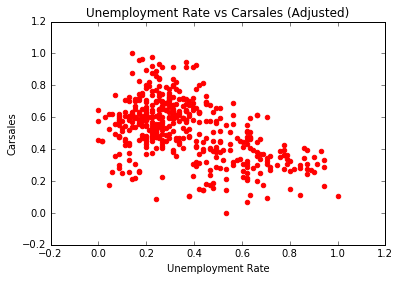

----------------------------------------------------


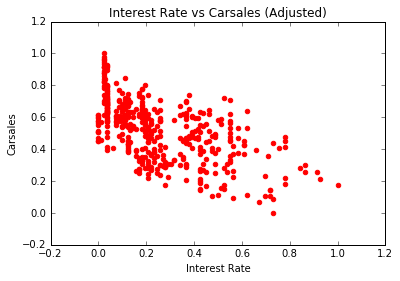

----------------------------------------------------


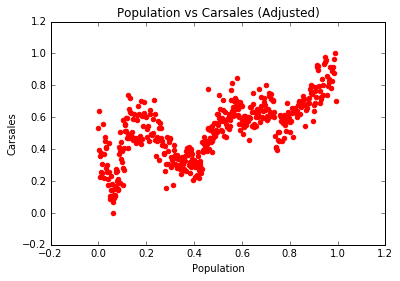

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot correlation between Unemployment and Car Sales
plt.scatter(unemp_ds.iloc[:, 1], carsales_ds.iloc[:, 1], color = 'red')
plt.title('Unemployment Rate vs Carsales (Adjusted)')
plt.xlabel('Unemployment Rate')
plt.ylabel('Carsales')
plt.show()
print("----------------------------------------------------")

# Plot correlation between Interest Rates and Car Sales

plt.scatter(interest_ds.iloc[:, 1], carsales_ds.iloc[:, 1], color = 'red')
plt.title('Interest Rate vs Carsales (Adjusted)')
plt.xlabel('Interest Rate')
plt.ylabel('Carsales')
plt.show()
print("----------------------------------------------------")

# Plot correlation between Population and Car Sales

plt.scatter(population_ds.iloc[0:-3, 1], carsales_ds.iloc[0:-3:, 1], color = 'red')
plt.title('Population vs Carsales (Adjusted)')
plt.xlabel('Population')
plt.ylabel('Carsales')
plt.show()



In [59]:
# Normalizing data using MinMaxScaler
# TODO: Create new copies
from sklearn.preprocessing import MinMaxScaler

# Interest Rates
interest_scaler = MinMaxScaler()
interest_values = np.array(interest_ds.iloc[:, 1:])
interest_scaled = interest_scaler.fit_transform(interest_values)
interest_ds_normal = interest_ds
interest_ds_normal.iloc[:, 1:] = interest_scaled
print(interest_ds_normal.head())
print("-----------------------------------")
#b = scaler.inverse_transform(scaled)

# Unemployement Rates
unemp_scaler = MinMaxScaler()
unemp_values = np.array(unemp_ds.iloc[:, 1:])
unemp_scaled = unemp_scaler.fit_transform(unemp_values)
unemp_ds_normal = unemp_ds
unemp_ds_normal.iloc[:, 1:] = unemp_scaled
print(unemp_ds_normal.head())
print("-----------------------------------")


# Population Rates
population_scaler = MinMaxScaler()
population_values = np.array(population_ds.iloc[:, 1:].astype(float))
population_scaled = population_scaler.fit_transform(population_values)
population_ds_normal = population_ds
population_ds_normal.iloc[:, 1:] = population_scaled
print(population_ds_normal.head())
print("-----------------------------------")


# Car Sales
carsales_scaler = MinMaxScaler()
carsales_values = np.array(carsales_ds.iloc[:, 1:].values.astype(float))
carsales_scaled = carsales_scaler.fit_transform(carsales_values)
carsales_ds_normal = carsales_ds
carsales_ds_normal.iloc[:, 1:] = carsales_scaled
print(carsales_ds_normal.head())

  Ref_Date  Interest_Rate
0   Jan-80       0.621951
1   Feb-80       0.621951
2   Mar-80       0.658537
3   Apr-80       0.707317
4   May-80       0.560976
-----------------------------------
  ﻿Ref_Date  Unemp_Rate
0    Jan-80    0.281690
1    Feb-80    0.309859
2    Mar-80    0.309859
3    Apr-80    0.323944
4    May-80    0.267606
-----------------------------------
  Ref_date  Population
0   Jan-80           0
1   Feb-80  0.00213573
2   Mar-80  0.00427153
3   Apr-80  0.00640726
4   May-80  0.00854298
-----------------------------------
  Ref_Date     Value
0   Jan-80  0.534592
1   Feb-80  0.637018
2   Mar-80  0.392845
3   Apr-80  0.357643
4   May-80  0.224484


# Prepare the data for regression
Merge feature data with car sales data and put into the format expected for regression.

In [10]:
# merged_ds: Month-Year, Unemployment Rate, Interest Rate, Population, Carsales                               
merged_ds = np.append(arr = unemp_ds_normal, values = interest_ds_normal.iloc[:, 1:], axis = 1)                
merged_ds = np.append(arr = merged_ds, values = population_ds_normal.iloc[:, 1:], axis = 1)  
merged_ds = np.append(arr = merged_ds, values = carsales_ds_normal.iloc[:, 1:], axis = 1) 
merged_ds = pd.DataFrame(merged_ds)
                              
# Breaking into independent variables and dependent variables
X = merged_ds.iloc[:, 1:4].values
Y = merged_ds.iloc[:, 4].values
print("Array of [Unemployement rate, interest rate, population] [First 5]")
print(X[0:5])
print("-----------------------------------")
print("Vector of Carsales (Adjusted) [First 5]")
print(Y[0:5])

Array of [Unemployement rate, interest rate, population] [First 5]
[[0.2816901408450704 0.6219512195121951 0.6675495049079552]
 [0.3098591549295775 0.6219512195121951 0.6682629463793343]
 [0.3098591549295775 0.6585365853658537 0.6689764151302405]
 [0.3239436619718311 0.7073170731707318 0.6696898566016196]
 [0.267605633802817 0.5609756097560976 0.6704032980729987]]
-----------------------------------
Vector of Carsales (Adjusted) [First 5]
[0.5345923169688418 0.6370176442611155 0.39284549825595716
 0.35764271632758105 0.2244840442626056]


# Apply linear regression on the prepared data
Apply multiple linear regression on the prepared data to get the prediction model.

In [11]:
# Linear Multiple Regression
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X, Y) 
print("Coef: " + str(regressor.coef_))
print("Intercept: " + str(regressor.intercept_))

Coef: [-0.44754313 -0.54870289  0.07326962]
Intercept: 0.761230016051


# Validate using randomly selected training and test sets
To validate the model, select random training and test subsets of the data (70% training and 30% test), apply the model on the test set, and calculate the resulting error.

In [12]:
# validate by getting mean squared error from using randomly selected test and training sets
from sklearn.cross_validation import train_test_split
# train_test_split(df, test_size = 0.2)
trainingData, testData = train_test_split(merged_ds, test_size = 0.3)
Xtrain = trainingData.iloc[:, 1:4].values
Ytrain = trainingData.iloc[:, 4].values
Xtest = testData.iloc[:, 1:4].values
Ytest = testData.iloc[:, 4].values
regressortrain = LinearRegression()
regressortrain.fit(Xtrain, Ytrain)
print("Coef: " + str(regressortrain.coef_))
print("Intercept: " + str(regressortrain.intercept_))
pred_train = regressortrain.predict(Xtrain)
pred_test = regressortrain.predict(Xtest)

print ("Fit a model Xtrain, and calculate mean squared error with Ytrain:", np.mean((Ytrain - pred_train) ** 2))
print ("Fit a model Xtrain, and calculate mean squared error with Xtest, Ytest:", np.mean((Ytest - pred_test) ** 2))


Coef: [-0.47236888 -0.57312996  0.02414215]
Intercept: 0.82272407115
Fit a model Xtrain, and calculate mean squared error with Ytrain: 0.013371105813009846
Fit a model Xtrain, and calculate mean squared error with Xtest, Ytest: 0.011175349523597493


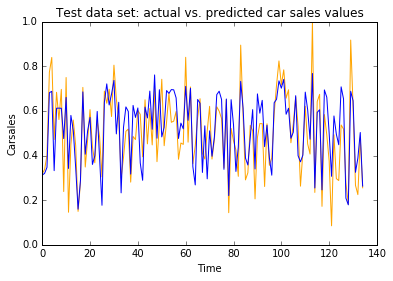

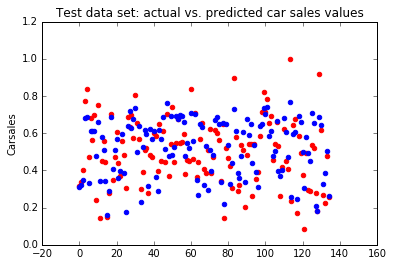

----------------------------------------------------


In [13]:
# Plot actual vs. predicted car sales for test data set
date_num_ref = range(0, len(Ytest))
plt.plot(date_num_ref, Ytest, color = 'orange')
plt.plot(date_num_ref, pred_test, color = 'blue')
plt.title('Test data set: actual vs. predicted car sales values')
plt.xlabel('Time')
plt.ylabel('Carsales')
plt.show()

# Dependency with unemployment rates
plt.scatter(date_num_ref, Ytest, color = 'red')
plt.scatter(date_num_ref, pred_test, color = 'blue')
plt.title('Test data set: actual vs. predicted car sales values')
plt.xlabel('')
plt.ylabel('Carsales')
plt.show()
print("----------------------------------------------------")



# Plot correlation between features and predicted car sales
Now that we have a prediction model, superimpose the graphs showing predicted car sales with our features on top of the graphs we have already generated for actual car sales / feature. For all three features (lower unemployment and interest rates correspond with higher car sales, as expected) we see a correlation with predicted car sales, with an especially close correlation for population between actual and predicted car sales.

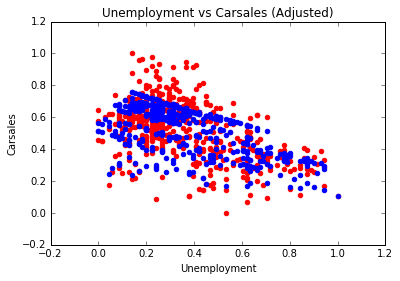

----------------------------------------------------


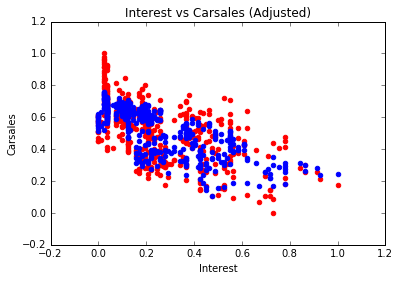

----------------------------------------------------


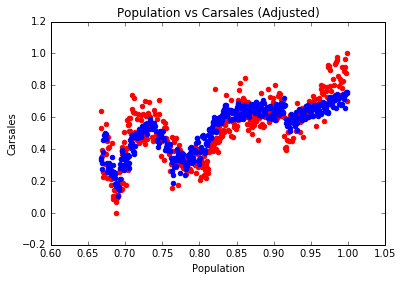

In [14]:
# Prediction graphs using our regressor

# Dependency with unemployment rates
plt.scatter(X[0:-3, 0], (pd.DataFrame(Y)).iloc[0:-3, 0], color = 'red')
plt.scatter(X[0:-3, 0], regressor.predict(X[0:-3, :]), color = 'blue')
plt.title('Unemployment vs Carsales (Adjusted)')
plt.xlabel('Unemployment')
plt.ylabel('Carsales')
plt.show()
print("----------------------------------------------------")


# Dependency with interest rates
plt.scatter(X[0:-3, 1], (pd.DataFrame(Y)).iloc[0:-3, 0], color = 'red')
plt.scatter(X[0:-3, 1], regressor.predict(X[0:-3, :]), color = 'blue')
plt.title('Interest vs Carsales (Adjusted)')
plt.xlabel('Interest')
plt.ylabel('Carsales')
plt.show()
print("----------------------------------------------------")


# Dependency with population
plt.scatter(X[0:-3, 2], (pd.DataFrame(Y)).iloc[0:-3, 0], color = 'red')
plt.scatter(X[0:-3, 2], regressor.predict(X[0:-3, :]), color = 'blue')
plt.title('Population vs Carsales (Adjusted)')
plt.xlabel('Population')
plt.ylabel('Carsales')
plt.show()

# Plot actual car sales over time vs. prediction from training set
Finally, superimpose the predicted car sales over time (shown in blue) on top of the actual sales over time (shown in orange). This plot demonstrates that our model tracks closely to actual new car sales (shown in orange) over time.

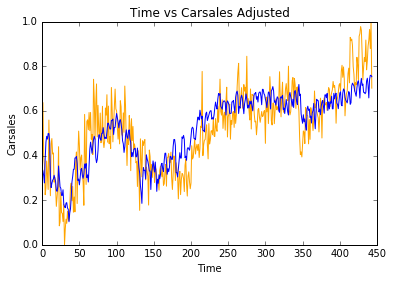

In [15]:
# Actual car sales with time vs predicted car sales with time
# 0 refers to Jan-1980, and every consecutive number thereafter is next consecutive month
date_num_ref = range(0, 444)
plt.plot(date_num_ref, carsales_ds_normal.iloc[0:-3, 1], color = 'orange')
plt.plot(date_num_ref, regressor.predict(X[0:-3, :]), color = 'blue')
plt.title('Time vs Carsales Adjusted')
plt.xlabel('Time')
plt.ylabel('Carsales')
plt.show()
